# Estimating Pareto fronts using random samples

## Imports

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import bofire.strategies.api as strategies
from bofire.benchmarks.api import BNH, Benchmark
from bofire.data_models.strategies.api import MoboStrategy, RandomStrategy
from bofire.utils.multiobjective import get_pareto_front


SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_INIT_SAMPLES = 12 if not SMOKE_TEST else 20
NUM_SAMPLES = 10000 if not SMOKE_TEST else 100

## Introduction

In this notebook, we will take a simple multiobjective example and train surrogate models for each output. Then we will use a simple random sampling approach to estimate the Pareto front, which is the set of best possible compromises between the objectives. Here we will not do any Bayesian optimization iterations; we merely demonstrate the random sampling approach for Pareto fronts, which can provide a baseline for Pareto-front estimation methods.

You can compare this naive approach with the more sophisticated method in, e.g., the [tutorial for the ZDT1 benchmark](https://github.com/experimental-design/bofire/blob/main/tutorials/benchmarks/011-ZDT1.ipynb). The random-sampling approach in this notebook will not work well for higher-dimensional problems because we are just hoping that some random samples will fall near the Pareto front and need to be extremely lucky for this to be the case when there are many dimensions.

## Generating the initial data for modeling

This function gives us a random dataset (including the 'measured' outputs) for the benchmark BNH, which has its own [tutorial](https://github.com/experimental-design/bofire/blob/main/tutorials/benchmarks/012-BNH.ipynb).

In [ ]:
def sample(benchmark: Benchmark, Nsamples: int = 10, inputs_only=False):
    datamodel = RandomStrategy(domain=benchmark.domain)
    sampler = strategies.map(data_model=datamodel)
    samples = sampler.ask(Nsamples)
    return samples if inputs_only else benchmark.f(samples, return_complete=True)

Let's use the function to generate the dataset that we will use for modeling:

In [ ]:
bnh = BNH()
init_data = sample(bnh, Nsamples=NUM_INIT_SAMPLES)
init_data.head()

,x1,x2,f1,f2,c1,c2,valid_c1,valid_c2,valid_f1,valid_f2
0,3.235181,1.897152,56.262340,12.742250,6.713771,46.685594,1,1,1,1
1,0.944766,2.871801,36.559290,20.974156,24.692165,84.254376,1,1,1,1
2,4.620137,2.464522,109.678133,6.572943,6.218167,41.284482,1,1,1,1
3,2.993973,1.165587,41.289861,18.726870,5.382738,42.412421,1,1,1,1
4,1.476776,0.990304,12.646279,28.490769,13.393807,58.474973,1,1,1,1


## Train

Next, we train models on the outputs using the `MoboStrategy`

In [ ]:
datamodel = MoboStrategy(domain=bnh.domain)
mobo_strat = strategies.map(data_model=datamodel)
mobo_strat.tell(init_data)

## Estimate the Pareto front

We generate a large number of random samples, use the `MoboStrategy` to get predictions for each sample, then discard those that are dominated in the Pareto sense with respect to the predicted outputs.

In this code block we get the samples:

In [ ]:
dense_samples = sample(bnh, Nsamples=NUM_SAMPLES, inputs_only=True)
dense_samples = pd.concat([dense_samples, mobo_strat.predict(dense_samples)], axis=1)
dense_samples.rename(columns={"f1_pred": "f1", "f2_pred": "f2"}, inplace=True)
dense_samples["valid_f1"] = 1
dense_samples["valid_f2"] = 1
dense_samples.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,x1,x2,c1_pred,c2_pred,f1,f2,c1_sd,c2_sd,f1_sd,f2_sd,f1_des,f2_des,c1_des,c2_des,valid_f1,valid_f2
0,4.824193,1.418243,2.936403,32.164223,96.224058,12.813320,0.878153,1.507216,3.744860,1.108512,-96.224058,-12.813320,1.0,1.0,1,1
1,2.406195,1.414166,8.614710,50.625390,30.881127,19.762983,0.433521,0.821362,1.621519,0.591357,-30.881127,-19.762983,1.0,1.0,1,1
2,1.286647,1.204312,15.428966,63.005427,12.103810,28.668753,0.456731,0.867202,1.669497,0.625886,-12.103810,-28.668753,1.0,1.0,1,1
3,2.429053,2.916580,14.891103,65.707672,55.993033,10.877458,0.818691,1.394782,3.607390,1.067341,-55.993033,-10.877458,1.0,1.0,1,1
4,2.967768,1.533018,6.255027,45.460447,44.682814,16.057206,0.421102,0.801401,1.540146,0.574769,-44.682814,-16.057206,1.0,1.0,1,1


and here we filter down to only the non-dominated points:

In [ ]:
estimated_front = get_pareto_front(domain=bnh.domain, experiments=dense_samples)

## Visualize the results

Plot the pareto front from this method and compare with the theoretical result. Remember that we only used 20 observations of the black-box function to estimate the front in this way; everything else was evaluations of our trained surrogates, which is very cheap

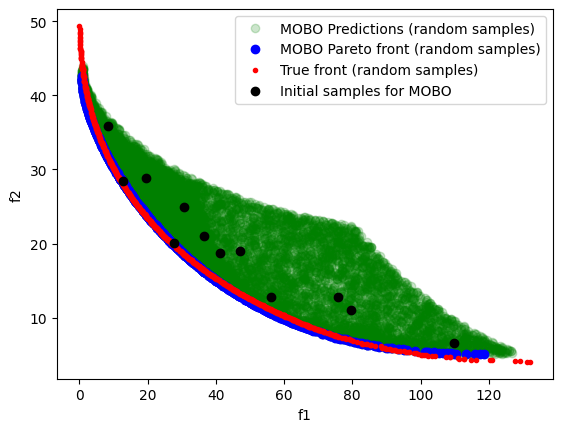

In [ ]:
true_front = get_pareto_front(
    domain=bnh.domain, experiments=sample(bnh, Nsamples=NUM_SAMPLES)
)

fig, ax = plt.subplots()
ax.plot(
    dense_samples.f1,
    dense_samples.f2,
    "o",
    alpha=0.2,
    label="MOBO Predictions (random inputs)",
    color="green",
)
ax.plot(
    estimated_front.f1, estimated_front.f2, "o", label="MOBO Pareto front", color="blue"
)
ax.plot(
    true_front.f1,
    true_front.f2,
    "o",
    markersize=3,
    label="True front (non-dominated random samples)",
    color="red",
)
ax.plot(
    init_data.f1, init_data.f2, "o", label="Initial samples for MOBO", color="black"
)
ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.legend()
plt.show()